In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats


In [95]:
#recupération de la variable 

df_clean = pd.read_pickle('df_clean.pkl')

df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Normalisation du jeu de données

In [96]:
df_clean['smoker']= (df_clean['smoker']=="yes").astype(int)
df_clean['sex']= (df_clean['sex']=='male').astype(int)
for region in df_clean['region'].unique():
    r = f'is_{region}'
    df_clean[r] = 0
    df_clean.loc[df_clean['region'] == region, r] = 1
df_clean.drop('region', axis=1, inplace=True)
df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast
0,19,0,27.900,0,1,16884.92400,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0
1334,18,0,31.920,0,0,2205.98080,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0
1336,21,0,25.800,0,0,2007.94500,1,0,0,0


<Axes: >

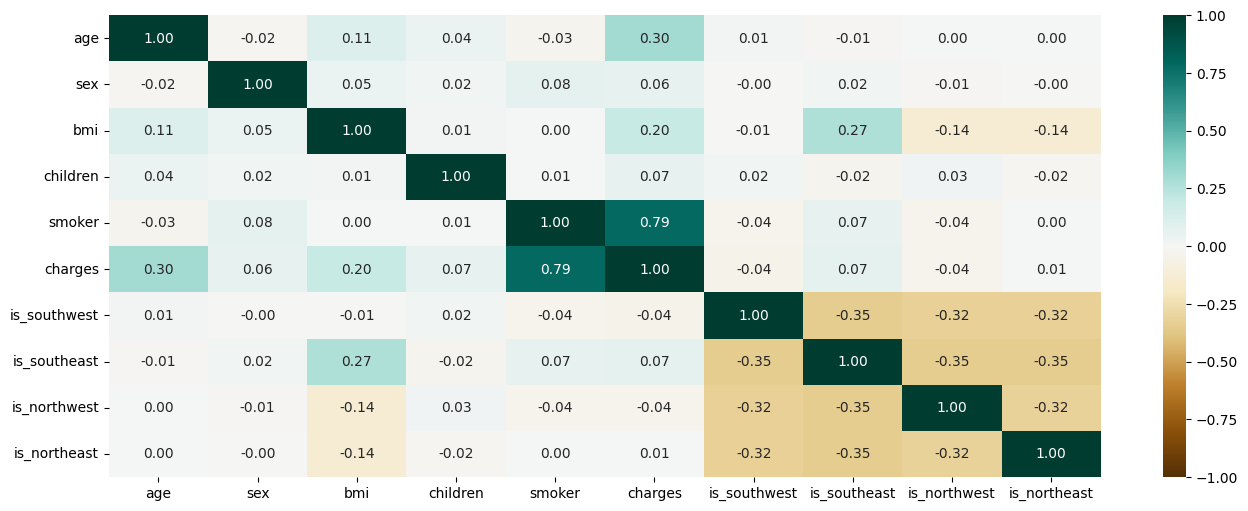

In [97]:

plt.figure(figsize=(16, 6))
sns.heatmap(df_clean.corr(method='pearson'), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG')

Nous remarquons plusieurs correlations avec la target :
- charges/smoke 0.79
- charges/age 0.3
- charges/bmi 0.20

De plus, nous observons une corrélation entre deu variables "indépendantes":
- region southeast/bmi

Par conséquent, nous procéderons de la manière suivante:

- Représentation ScatterPlot pour l'annalyse charges/age et charges/bmi
- Confirmation de la relation via Anova pour charges/smoke et region southeast/bmi






# Catégorisation BMI et Age

In [98]:
# catégorisation des ages
intervals = [(18, 35, 1), (36, 50, 2), (51, 70, 3), (71, 200, 4)]
df_clean['age_cat'] = pd.Series()

for interval in intervals:
    min, max, name = interval
    col = f'{min}_{max}'
    df_clean[col] = 0
    df_clean.loc[(df_clean.age >= min) & (df_clean.age <= max), 'age_cat'] = col
    df_clean.loc[(df_clean.age >= min) & (df_clean.age <= max), col] = 1

In [99]:
# catégorisation de bmi
intervals = [(0, 18.5, 'underweight'), (18.50001, 25, 'normal'), (25.0001, 30, 'overweight'), (30.00001, 200, 'obesity')]
df_clean['bmi_cat'] = pd.Series()

for interval in intervals:
    min, max, name = interval
    col = name
    df_clean[col] = 0
    df_clean.loc[(df_clean.bmi >= min) & (df_clean.bmi <= max), 'bmi_cat'] = col
    df_clean.loc[(df_clean.bmi >= min) & (df_clean.bmi <= max), col] = 1
    
df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast,age_cat,18_35,36_50,51_70,71_200,bmi_cat,underweight,normal,overweight,obesity
0,19,0,27.900,0,1,16884.92400,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
2,28,1,33.000,3,0,4449.46200,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
3,33,1,22.705,0,0,21984.47061,0,0,1,0,18_35,1,0,0,0,normal,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,18_35,1,0,0,0,overweight,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0,36_50,0,1,0,0,obesity,0,0,0,1
1334,18,0,31.920,0,0,2205.98080,0,0,0,1,18_35,1,0,0,0,obesity,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
1336,21,0,25.800,0,0,2007.94500,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0


# Analyse

## Analyse Age/charges


In [100]:

a,b,r,p,_ = stats.linregress(df_clean.age, df_clean.charges)

a,b,r,p



(257.2297175179149,
 3190.0217210318224,
 0.2983082125097864,
 6.975748762691313e-29)

Nous remarquons une forte corrélation entre l'age et les charges, le calcul de la p-value et du coefficient de Pearson l'attestent

<Figure size 640x480 with 0 Axes>

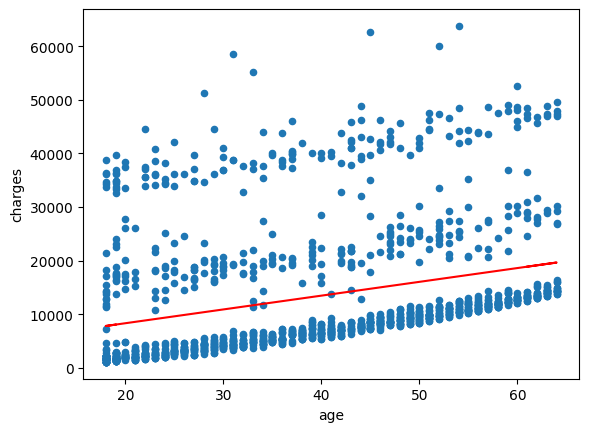

In [101]:
plt.figure(1)
df_clean.plot('age','charges',kind='scatter')
plt.figure(2)
plt.plot(df_clean.age, a*df_clean.age + b , 'red')


## Analyse BMI/charges

In [102]:
a,b,r,p,_ = stats.linregress(df_clean.bmi, df_clean.charges)

a,b,r,p


(393.8558912099734,
 1202.1403670662148,
 0.1984008312262494,
 2.4680404264512973e-13)

<Figure size 640x480 with 0 Axes>

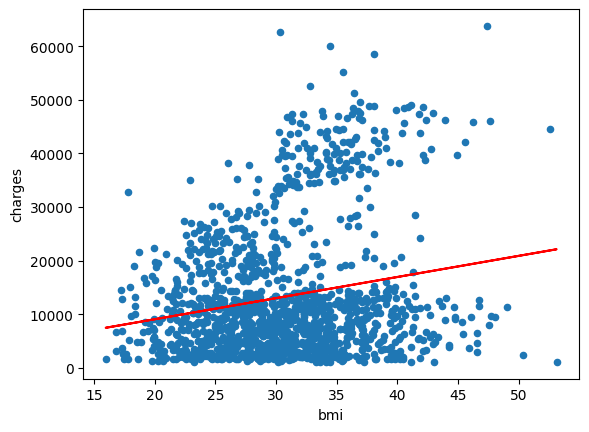

In [124]:
plt.figure(1)
df_clean.plot('bmi','charges',kind='scatter')
plt.figure(2)
plt.plot(df_clean.bmi, a*df_clean.bmi + b , 'red')



## Analyse Smoker/Charges


Anova est un modèle d'analyse qui permet de comparer la variation d'une variable qualitative et d'une variable quantitative

<Axes: title={'center': 'charges'}, xlabel='smoker'>

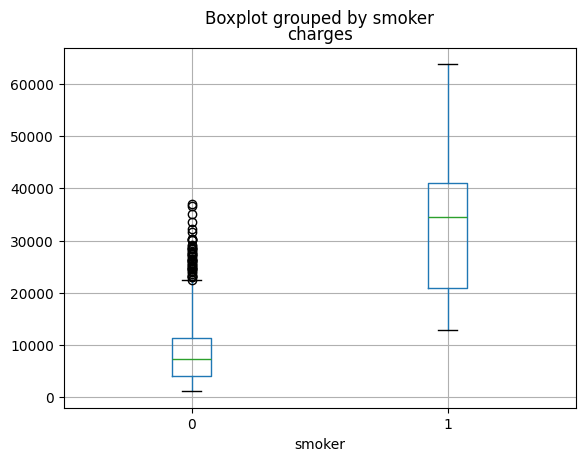

In [104]:
# boxplot

df_clean.boxplot('charges', by='smoker')

Nous soulignons une varaition significative de la médiane que l'observation soit fumeuse ou non. L'observation de plusieurs valeurs atypiques laisse penser que d'autres variables ont une influence significative avec la charge.
Nous allons vérifier avec le modèle Anova cad l'analyse de la variance.

In [105]:
statf,pvalue = stats.f_oneway(df_clean.charges[df_clean.smoker==1],df_clean.charges[df_clean.smoker==0])
statf,pvalue

(2175.7368631272116, 1.4067220949358597e-282)

Nous observons une pvalue très faible, ainsi nus rejetons l'hypothèse nulle. Cela veut dire qu'il y a un effet dans les données qui n'est pas dû au hasard.

## Analyse Southeast/BMI

<Axes: title={'center': 'bmi'}, xlabel='is_southeast'>

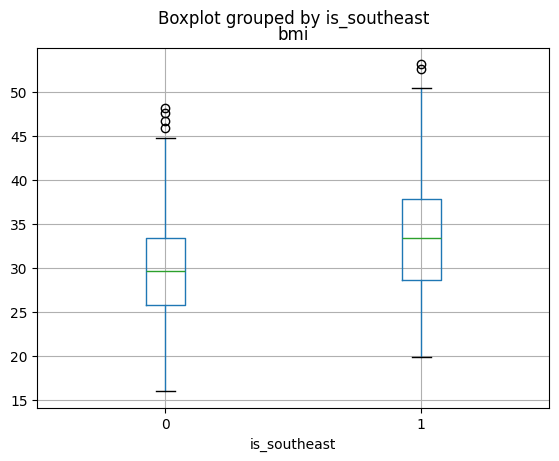

In [106]:
# boxplot

df_clean.boxplot('bmi', by='is_southeast')

In [107]:
statf,pvalue = stats.f_oneway(df_clean.bmi[df_clean.is_southeast==1],df_clean.bmi[df_clean.is_southeast==0])
statf,pvalue

(105.0218465125994, 8.933277252354888e-24)

## Analyse Bivariée


### Analyse bivariée entre deux variables quantitatives: cas du BMI et de la CHARGE

In [114]:
a,b,r,p,_ = stats.linregress(df_clean.bmi, df_clean.charges)

a,b,r,p

# a = coefficient de pente de la regression linéaire
# b = l'ordonnée à l'origine
# r = coefficient de corrélation. Valeur comprise entre -1< r < 1 avec -1 une forte correlation négative,
# 0 absence de correlation et 1 une forte corrélation positive.
# p = p_value (valeur de probabilité) permet evaluer la validité de H0 (hypothèse nulle) 
# cad absence effet ou de différence significative


(393.8558912099734,
 1202.1403670662148,
 0.1984008312262494,
 2.4680404264512973e-13)

Interpretation : Concernant le coefficient de corrélation, celui-ci s'élève à 0.1984 indiquant l'existance d'une corrélation positive mais faible. La relation netre les deux variables n'est pas très forte.
Cependant la p-value, avec une valeur très proche de 0, indique que cette corrélation observée n'est pas dûe au hasard. Donc ces deux variables sont biens corrélées.


Représentation : La corrélation entre deux varaibles quantitatives BMI et Charges est représentée par un diagramme de dispersion

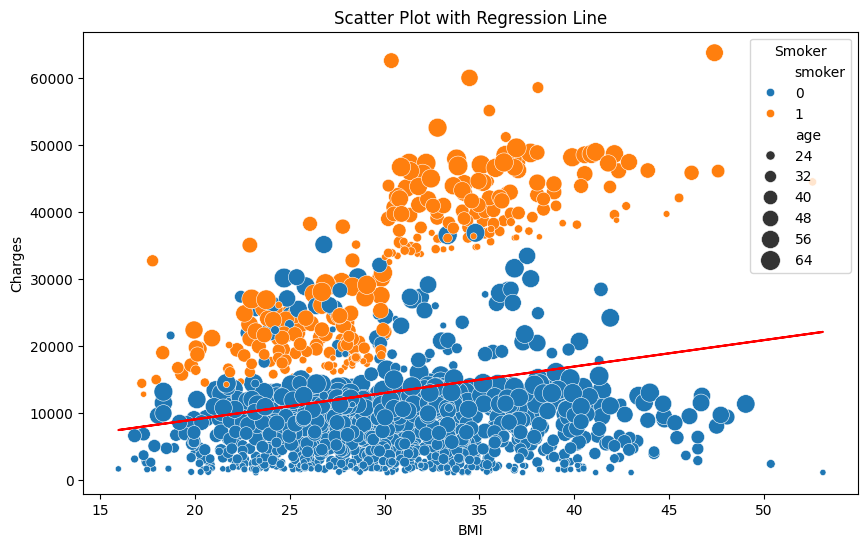

In [129]:
# plt.figure(1)
# sns.scatterplot(data= df_clean,x='bmi',y='charges',hue='smoker', size='age')
# plt.figure(2)
# plt.plot(df_clean.bmi, a*df_clean.bmi + b , 'red')


# Créer une figure avec un ensemble d'axes (sous-graphiques)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le nuage de points avec Seaborn sur les axes créés
sns.scatterplot(data=df_clean, x='bmi', y='charges', hue='smoker', size='age', ax=ax, sizes=(20,200))

# Tracer la ligne rouge sur les mêmes axes
ax.plot(df_clean.bmi, a * df_clean.bmi + b, 'red')

# Ajouter des étiquettes, un titre, une légende, etc.
ax.set_xlabel('BMI')
ax.set_ylabel('Charges')
ax.set_title('Scatter Plot with Regression Line')
ax.legend(title='Smoker')

# Afficher la figure
plt.show()


### Analyse bivariée entre une variables quantitative et une variable qualitative : cas du TABAGISME et de la CHARGE

In [131]:
df_clean.to_pickle('df_clean_final.pkl')